[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/masadcv/FastGeodis/blob/master/samples/demo2d_signed.ipynb)

In [25]:
! pip install FastGeodis wget -q

In [26]:
# import relevant libraries
import os
import time

import FastGeodis
import matplotlib.pyplot as plt
import numpy as np
import torch
import wget
from PIL import Image


In [27]:
# read images from local path or download from github repo (for colab)
gray_image_path = "../data/img2d.png"
color_image_path = "../data/ISIC_546.jpg"

if not os.path.exists(os.path.dirname(gray_image_path)):
    os.makedirs(os.path.dirname(gray_image_path), exist_ok=True)

wget.download("https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/img2d.png", gray_image_path) if not os.path.exists(gray_image_path) else None
wget.download("https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/ISIC_546.jpg", color_image_path) if not os.path.exists(color_image_path) else None

! ls ../data

brain.png	     image3d_dis2.nii.gz  img2d.png
brain_seg_noisy.png  image3d_dis3.nii.gz  img3d.nii.gz
brain_seg.png	     image3d_sub.nii.gz   ISIC_546.jpg


In [28]:
def evaluate_geodesic_distance2d(image, seed_pos):
    SHOW_JOINT_HIST = False
    # get image and create seed image
    input_image = np.asanyarray(image, np.float32)
    Seed = np.zeros((input_image.shape[0], input_image.shape[1]), np.float32)
    Seed[seed_pos[0]][seed_pos[1]] = 1

    # run and time each method
    iterations = 2
    v = 1e10
    lamb = 1.0

    if input_image.ndim == 3:
        input_image = np.moveaxis(input_image, -1, 0)
    else:
        input_image = np.expand_dims(input_image, 0)

    device = "cpu"
    input_image_pt = torch.from_numpy(input_image).unsqueeze_(0).to(device)
    seed_image_pt = (
        torch.from_numpy(1 - Seed.astype(np.float32))
        .unsqueeze_(0)
        .unsqueeze_(0)
        .to(device)
    )

    tic = time.time()
    fastmarch_output = np.squeeze(
        FastGeodis.signed_geodesic2d_fastmarch(
            input_image_pt, seed_image_pt, lamb
        )
        .cpu()
        .numpy()
    )
    fastmarch_time = time.time() - tic

    tic = time.time()
    toivanenraster_output = np.squeeze(
        FastGeodis.signed_generalised_geodesic2d_toivanen(
            input_image_pt, seed_image_pt, v, lamb, iterations
        )
        .cpu()
        .numpy()
    )
    toivanenraster_time = time.time() - tic

    tic = time.time()
    fastraster_output_cpu = np.squeeze(
        FastGeodis.signed_generalised_geodesic2d(
            input_image_pt, seed_image_pt, v, lamb, iterations
        )
        .cpu()
        .numpy()
    )
    fastraster_time_cpu = time.time() - tic

    device = "cuda" if torch.cuda.is_available() else None
    if device:
        input_image_pt = input_image_pt.to(device)
        seed_image_pt = seed_image_pt.to(device)

        tic = time.time()
        fastraster_output_gpu = np.squeeze(
            FastGeodis.signed_generalised_geodesic2d(
                input_image_pt, seed_image_pt, v, lamb, iterations
            )
            .cpu()
            .numpy()
        )
        fastraster_time_gpu = time.time() - tic

    print("Runtimes:")
    print(
        "Fast Marching CPU: {:.6f} s \nToivanen's CPU raster: {:.6f} s \nFastGeodis CPU raster: {:.6f} s".format(
            fastmarch_time, toivanenraster_time, fastraster_time_cpu
        )
    )

    if device:
        print("FastGeodis GPU raster: {:.6f} s".format(fastraster_time_gpu))
    
    plt.figure(figsize=(18, 6))
    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap="gray")
    plt.autoscale(False)
    plt.plot([seed_pos[0]], [seed_pos[1]], "ro")
    plt.axis("off")
    plt.title("(a) Input image")
    
    plt.subplot(2, 4, 5)
    plt.imshow(fastmarch_output)
    plt.axis("off")
    plt.title("(b) Fast Marching (cpu) | ({:.4f} s)".format(fastmarch_time))


    plt.subplot(2, 4, 2)
    plt.imshow(toivanenraster_output)
    plt.axis("off")
    plt.title("(c) Toivanen's Raster (cpu) | ({:.4f} s)".format(toivanenraster_time))

    plt.subplot(2, 4, 3)
    plt.imshow(fastraster_output_cpu)
    plt.axis("off")
    plt.title("(e) FastGeodis (cpu) | ({:.4f} s)".format(fastraster_time_cpu))

    plt.subplot(2, 4, 6)
    plt.imshow(toivanenraster_output)
    plt.axis("off")
    plt.title("(d) Toivanen's Raster (cpu) | ({:.4f} s)".format(toivanenraster_time))

    if device:
        plt.subplot(2, 4, 7)
        plt.imshow(fastraster_output_gpu)
        plt.axis("off")
        plt.title("(f) FastGeodis (gpu) | ({:.4f} s)".format(fastraster_time_gpu))

    diff = (
        abs(fastmarch_output - fastraster_output_cpu)
        / (fastmarch_output + 1e-7)
        * 100
    )
    plt.subplot(2, 4, 4)
    plt.imshow(diff)
    plt.axis("off")
    plt.title(
        "(g) Fast Marching vs. FastGeodis (cpu)\ndiff: max: {:.4f} | min: {:.4f}".format(
            np.max(diff), np.min(diff)
        )
    )

    if device:
        diff = (
            abs(fastmarch_output - fastraster_output_gpu)
            / (fastmarch_output + 1e-7)
            * 100
        )
        plt.subplot(2, 4, 8)
        plt.imshow(diff)
        plt.axis("off")
        plt.title(
            "(h) Fast Marching vs. FastGeodis (gpu)\ndiff: max: {:.4f} | min: {:.4f}".format(
                np.max(diff), np.min(diff)
            )
        )

    # plt.colorbar()
    plt.show()

    if SHOW_JOINT_HIST:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title("Joint histogram\nFast Marching (cpu) vs. Toivanen's Raster (cpu)")
        plt.hist2d(
            fastmarch_output.flatten(), toivanenraster_output.flatten(), bins=50
        )
        plt.xlabel("Fast Marching (cpu)")
        plt.ylabel("Toivanen's Raster (cpu)")

        plt.subplot(1, 3, 2)
        plt.title("Joint histogram\nFast Marching (cpu) vs. FastGeodis (cpu)")
        plt.hist2d(
            fastmarch_output.flatten(), fastraster_output_cpu.flatten(), bins=50
        )
        plt.xlabel("Fast Marching (cpu)")
        plt.ylabel("FastGeodis (cpu)")
        # plt.gca().set_aspect("equal", adjustable="box")

        if device:
            plt.subplot(1, 3, 3)
            plt.title("Joint histogram\nFast Marching (cpu) vs. FastGeodis (gpu)")
            plt.hist2d(
                fastmarch_output.flatten(),
                fastraster_output_gpu.flatten(),
                bins=50,
            )
            plt.xlabel("Fast Marching (cpu)")
            plt.ylabel("FastGeodis (gpu)")
            # plt.gca().set_aspect("equal", adjustable="box")

        plt.tight_layout()
        # plt.colorbar()
        plt.show()


def demo_geodesic_distance2d(image):
    # make image bigger to check how much workload each method can take
    scale = 6
    scaled_image_size = [x * scale for x in image.size]
    image = image.resize(scaled_image_size)
    seed_position = [100 * scale, 100 * scale]
    evaluate_geodesic_distance2d(image, seed_position)

Runtimes:
Fast Marching CPU: 4.822314 s 
Toivanen's CPU raster: 0.082317 s 
FastGeodis CPU raster: 0.076425 s
FastGeodis GPU raster: 0.014250 s


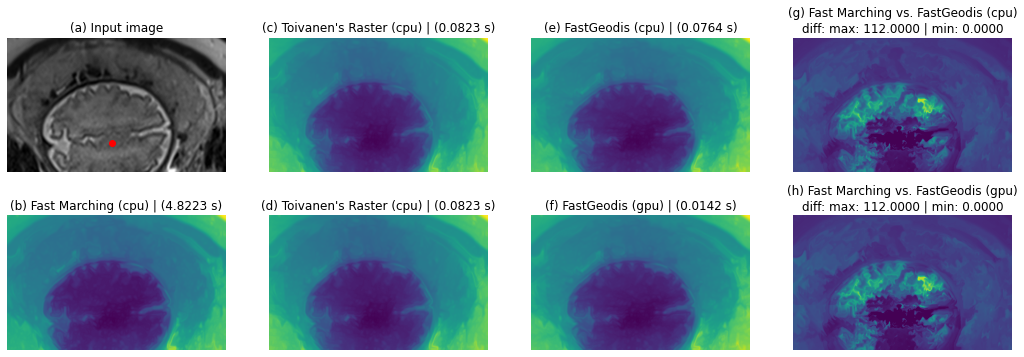

In [29]:
# "gray" or "color"
image = Image.open(gray_image_path).convert("L")
demo_geodesic_distance2d(image)

Runtimes:
Fast Marching CPU: 15.305027 s 
Toivanen's CPU raster: 0.391567 s 
FastGeodis CPU raster: 0.398181 s
FastGeodis GPU raster: 0.081922 s


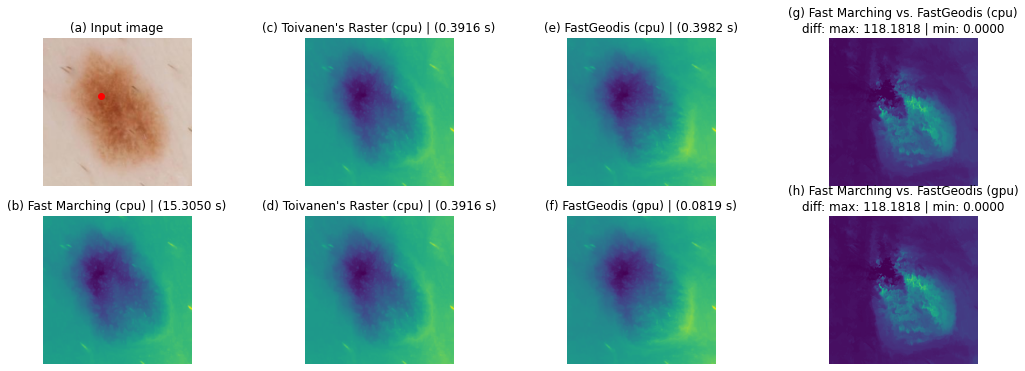

In [30]:
image = Image.open(color_image_path)
demo_geodesic_distance2d(image)